<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/SiDet2023/IVScan_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Init

In [1]:
import sys
import tarfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from scipy.optimize import curve_fit

# This allows you to run on Colaboratory and load files from your Google Drive
try:
    from google.colab import drive
    drive.mount("/content/drive")
    main_path = '/content/drive/MyDrive/'
except:
    main_path = ''
sys.path.append(main_path)
sys.path.append(main_path+'IVdata2023')
import math

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
plt.style.use('seaborn-whitegrid')
plt.rcParams["grid.linestyle"] = (5,15)
plt.rcParams["grid.linewidth"] = 0.7
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 22})

<ipython-input-2-217882b3f9df>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


#Process single file

In [3]:
#Function that returns the breakdown voltage using a parabola and linear fit
def getVbd(df, chan, debug = False):
    # Define the parabolic function
    def par_func(x, a, b, c):
        return a * x**2 + b * x + c
    # Define the linear function
    def lin_func(x, a, b):
        return a * x + b

    x=df.V.to_numpy()
    y=df.I_log.to_numpy()
    if debug:
        plt.plot(x, y, '-')

    Vbr = df['Vbr'].iloc[0]
    x_ = df.query('V>%f & V<%f'%(Vbr-0.1, Vbr+1.5)).V
    y_ = df.query('V>%f & V<%f'%(Vbr-0.1, Vbr+1.5)).I_log

    popt_par, pcov = curve_fit(par_func, x_, y_)
    if debug:
        plt.plot(x, par_func(x, *popt_par), 'r-')

    x_ = df.query('V<%f'%(Vbr-0.25)).V
    y_ = df.query('V<%f'%(Vbr-0.25)).I_log
    popt_lin, pcov = curve_fit(lin_func, x_, y_)
    if debug:
        plt.figure()
        plt.title("Channel: %d"%chan)
        plt.plot(x_, lin_func(x_, *popt_lin), 'r-')
        plt.ylim(-1,5)

    finex = np.arange(x.min(), x.max(), 0.01)
    f_par = par_func(finex, *popt_par)
    f_lin = lin_func(finex, *popt_lin)

    idx = np.argwhere(np.diff(np.sign(f_par - f_lin))).flatten()
    return finex[idx][0]

In [4]:
#Process a sinlge file from the tar file
df = pd.DataFrame()
file = 'drive/MyDrive/IVdata2023/etc.mu2e.CRV_wideband_cosmics.crviv-000.000020_000.tgz'
Temp = re.split('\.|_',file)[6].lstrip("0")
Temp = float(Temp)/100

with tarfile.open(file, 'r:gz') as tar:
    # Iterate over the files in the archive
    for member in tar.getmembers():
        # Extract the file
        if member.isdir():
            continue
        file = tar.extractfile(member)
        basename = os.path.basename(member.name)
        # Load the extracted file into a pandas DataFrame
        df_ = pd.read_csv(file, skiprows=8, header=0, names = ["V", "I"])  # Assuming the file is in CSV format
        split_name = basename.split("_")
        fpga = int(split_name[2][4:])
        chan = int(split_name[3][2:])
        df_['fpga'] = fpga
        df_['chan'] = chan + 16*fpga
        df_['I_log'] = np.log(df_['I'])
        df_['Temp'] = Temp*100
        # Calculate dLod(I)/dV to estimate the breakdown voltage
        df_coarse = df_.groupby(df_.index // 4).mean()
        df_['Vbr'] = df_coarse['V'][df_coarse['I_log'].diff().idxmax()]
        df_['Vbr_fit'] = getVbd(df_, chan + 16*fpga, False)
        df = pd.concat([df,df_], ignore_index=True)

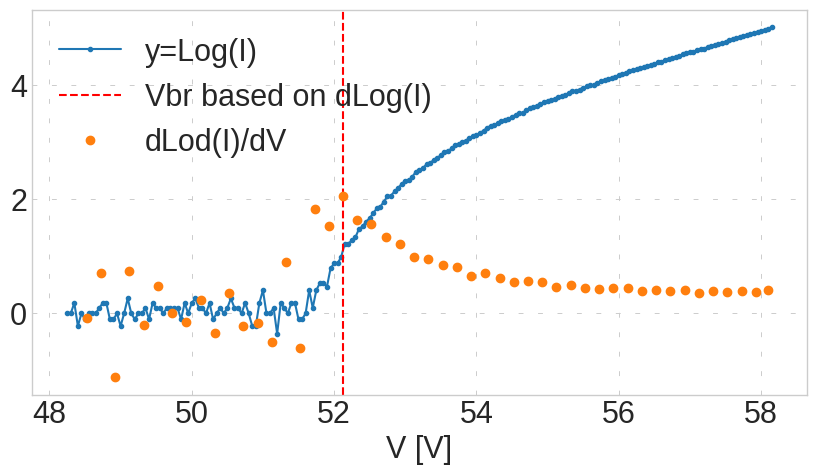

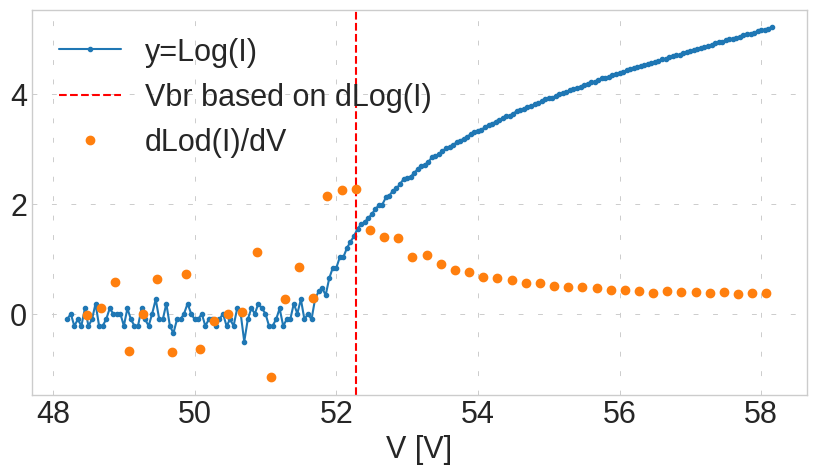

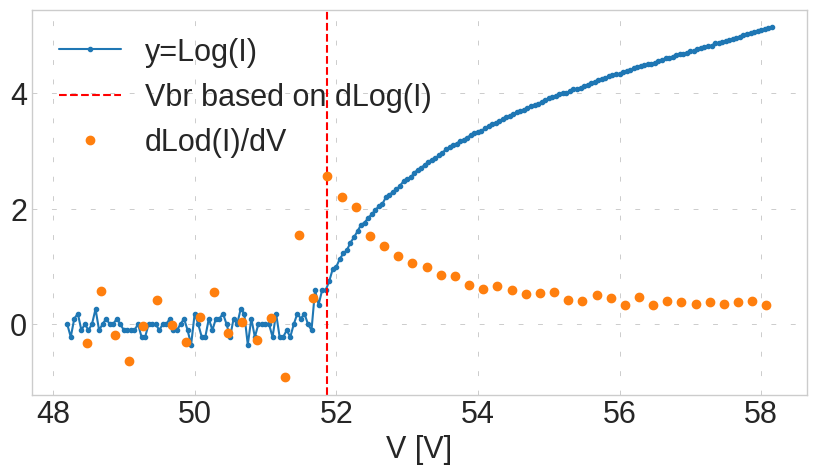

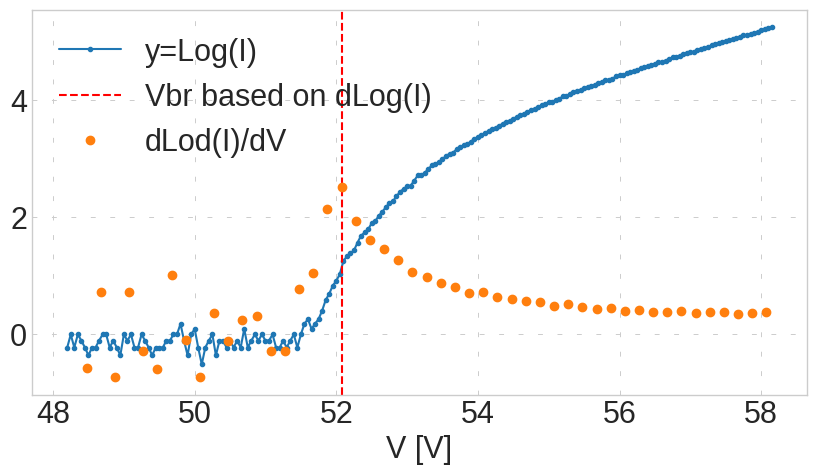

In [5]:
for chan in range(4):
  plt.figure()
  #Plot a single channel
  df1 = df.query("chan==%d"%chan).reset_index()
  plt.plot(df1.V, df1.I_log, '.-', label='y=Log(I)');
  plt.axvline(x=df1.Vbr[0], color='red', linestyle='--', label='Vbr based on dLog(I)')
  #plt.axvline(x=df1.Vbr_fit[0], color='red', linestyle='-.', label='Vbr based on fit')

  df_coarse = df1.groupby(df1.index // 4).mean()
  plt.plot(df_coarse['V'], df_coarse['I_log'].diff()/df_coarse['V'].diff(), 'o', label='dLod(I)/dV')
  plt.legend()
  plt.xlabel("V [V]")

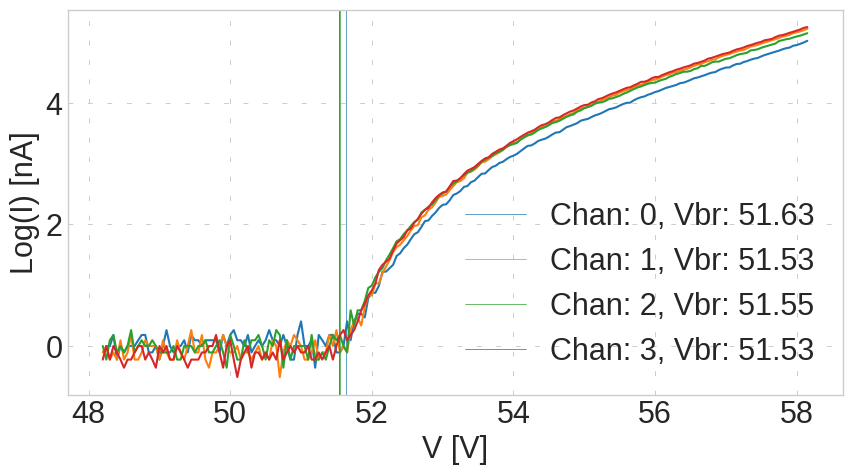

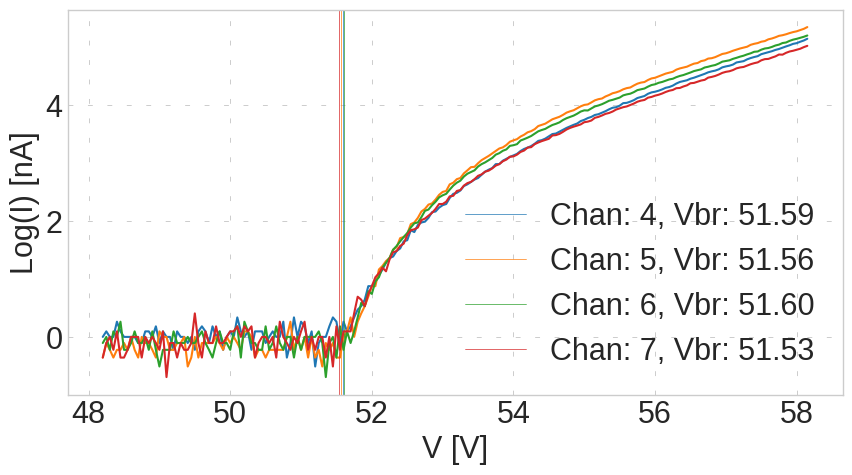

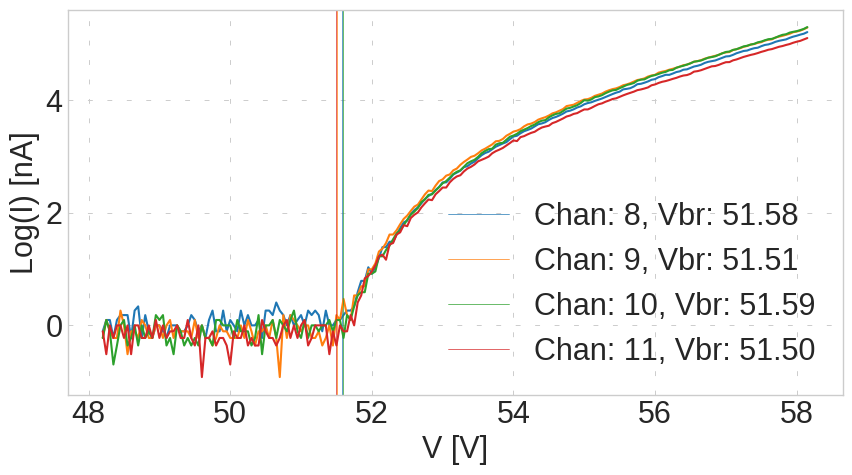

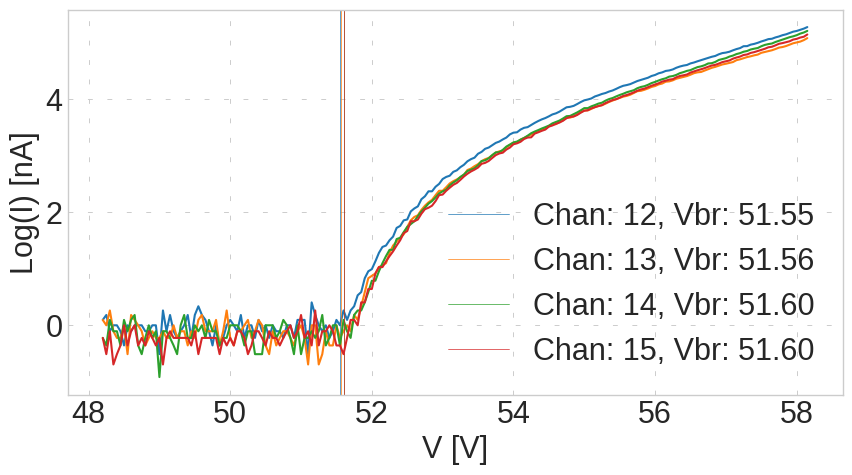

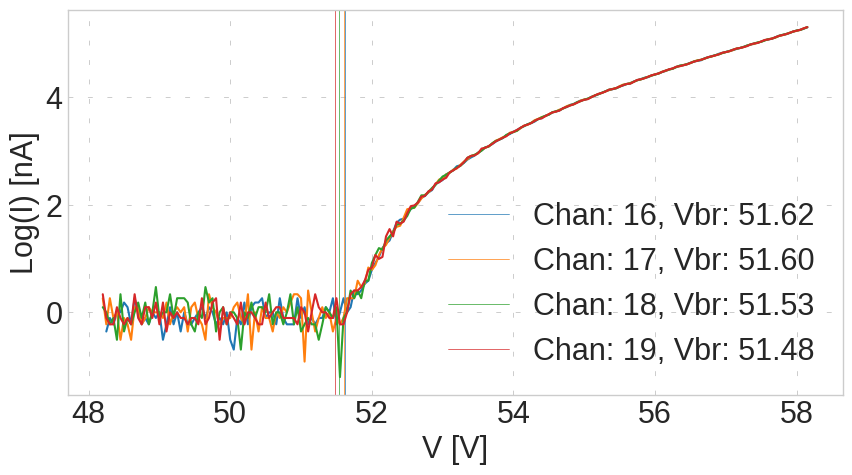

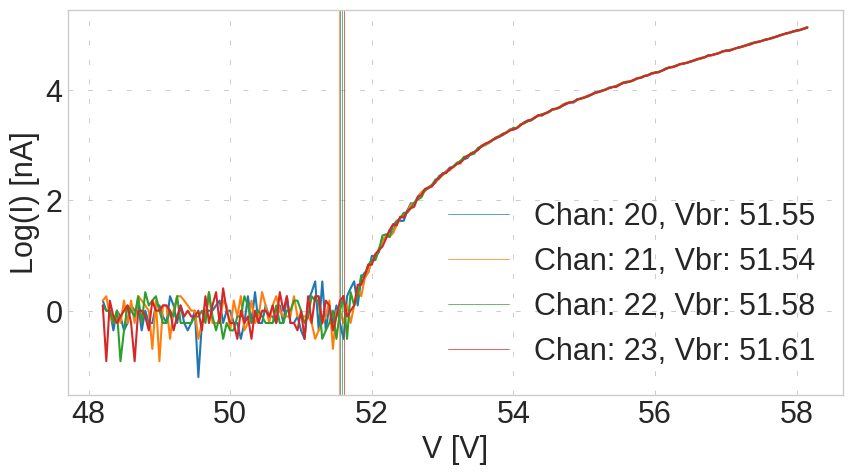

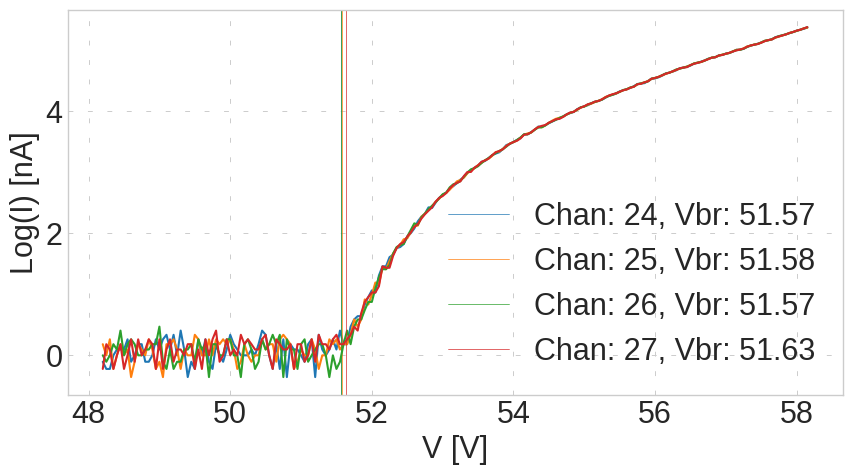

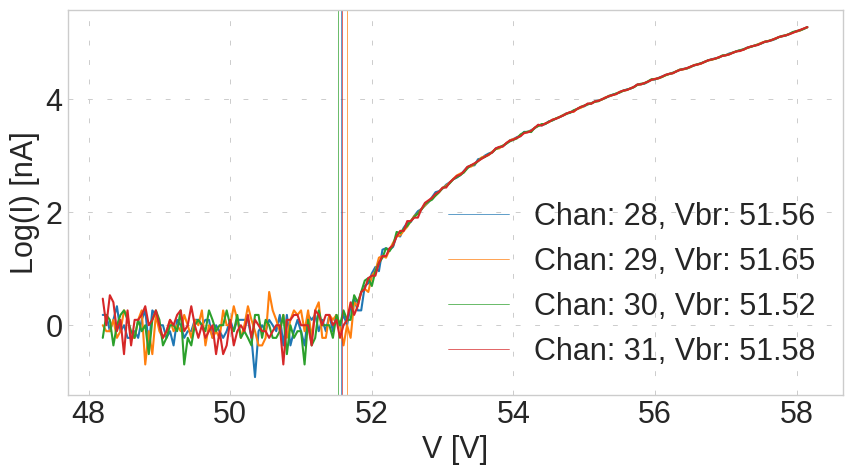

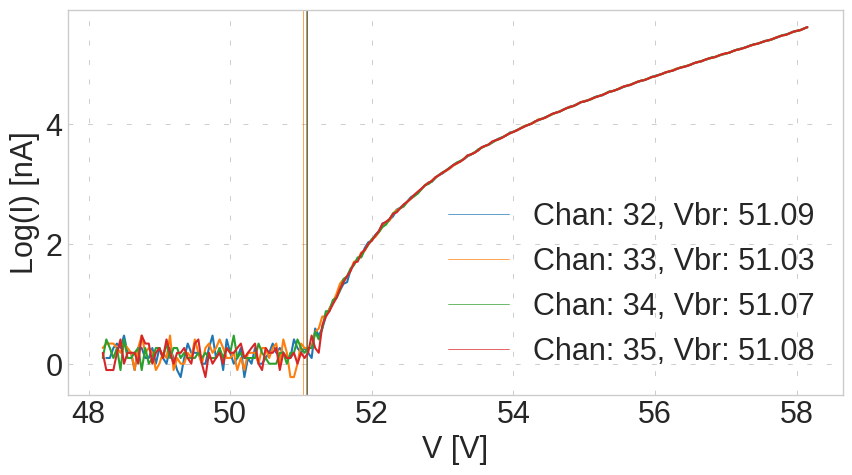

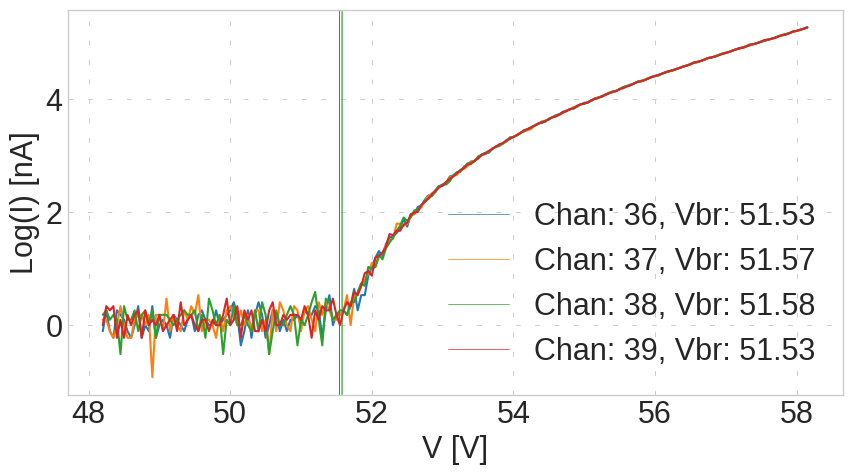

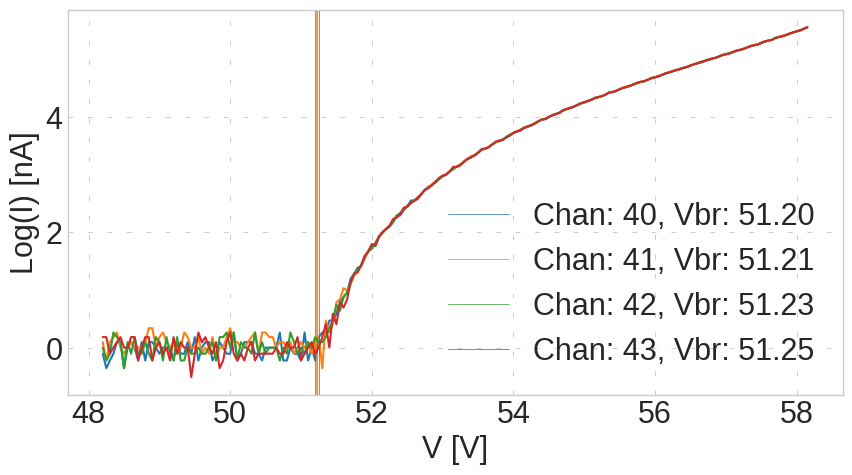

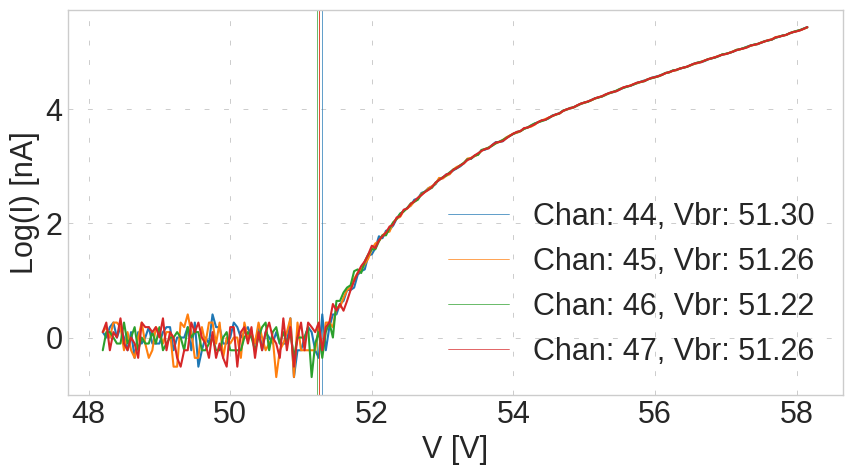

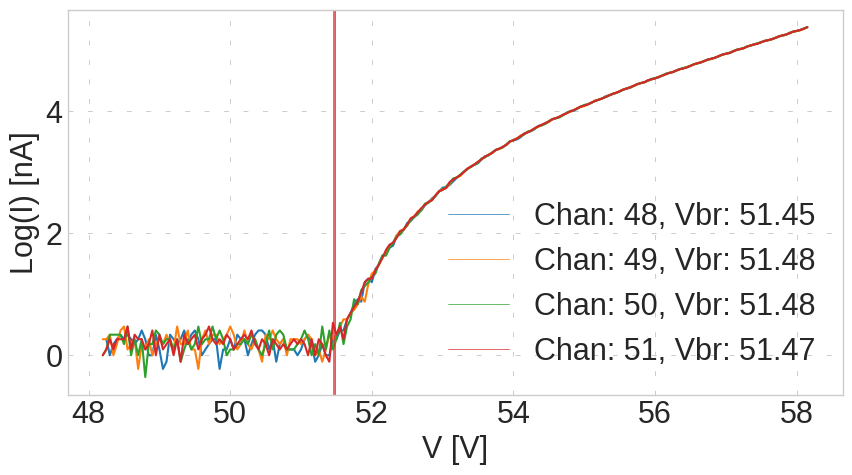

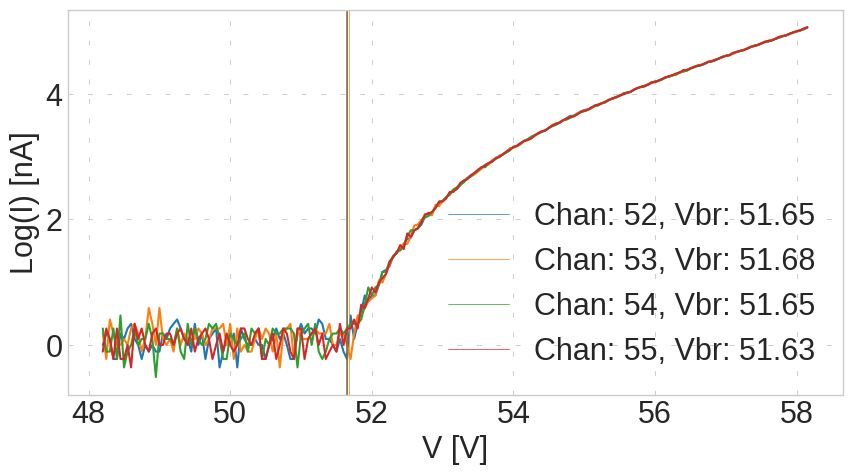

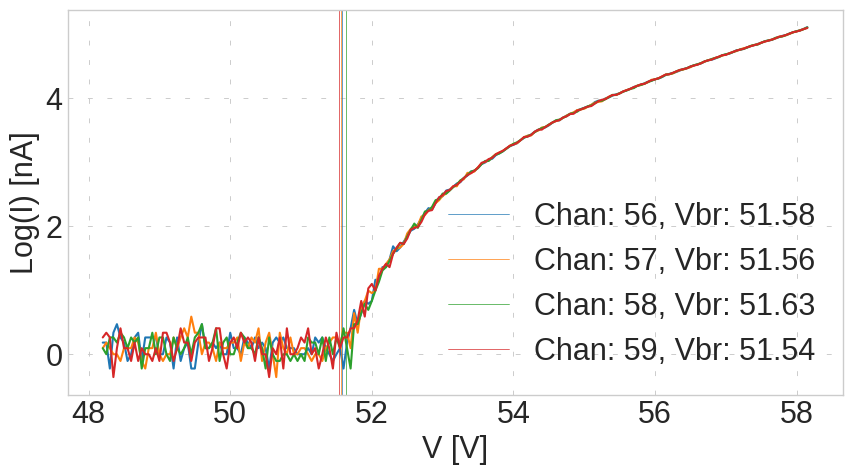

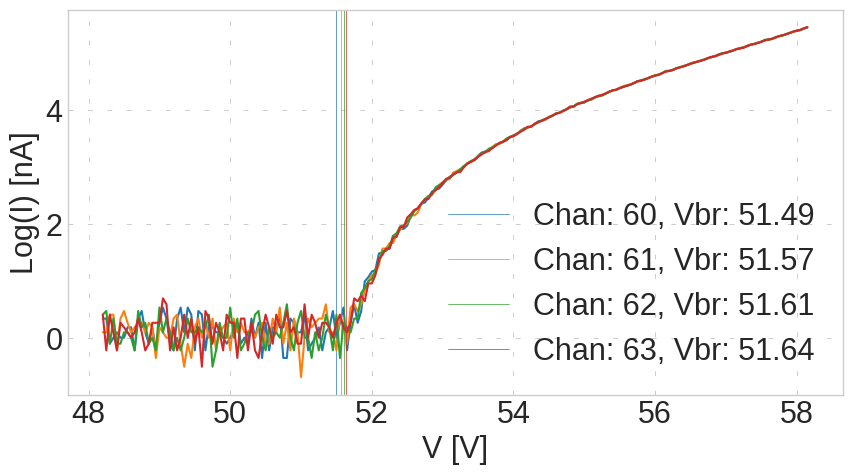

In [6]:
#Plot all channels
channels = df['chan'].unique()
channels = np.sort(channels)
for chan in channels:

    df2 = df.query('chan==%d'%chan)
    Vbr = df2['Vbr_fit'].iloc[0]

    if(chan%4 ==0):
        plt.figure()
    plts = plt.plot(df2.V, df2.I_log, '-')

    plt.axvline(x=Vbr, linestyle='-', color = plts[0].get_color(), linewidth=0.5,label='Chan: %d, Vbr: %.2f'%(chan, Vbr))
    plt.legend()
    plt.xlabel('V [V]')
    plt.ylabel('Log(I) [nA]')

Text(0.5, 1.0, 'Temp 20C')

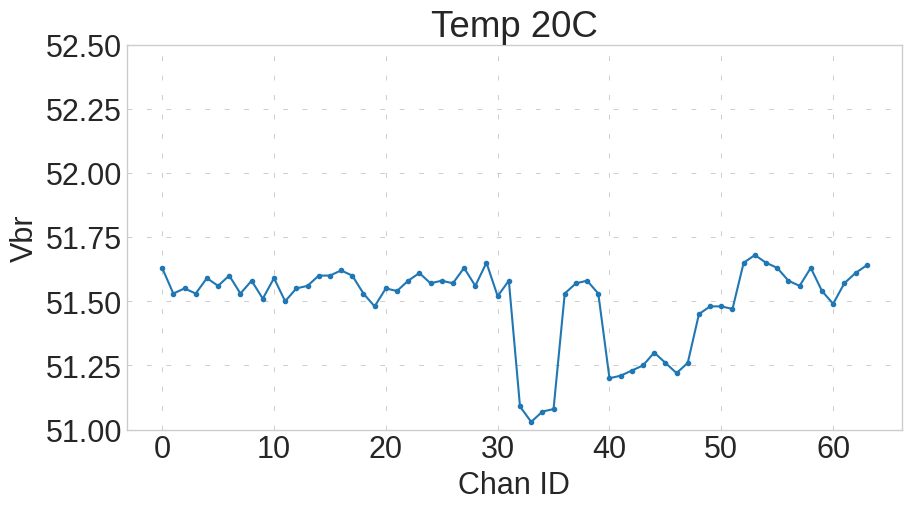

In [7]:
df_ = df.sort_values('chan').query('V==48.55')
plt.plot(df_['chan'], df_['Vbr_fit'], '.-')
plt.ylim(51, 52.5)
plt.xlabel('Chan ID')
plt.ylabel('Vbr');
plt.title('Temp 20C')